In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# step1:数据加载
data = pd.read_excel('./jobs_4k.xls')
print(data.head())
print(data.shape)
print(data.columns)

   id         positionName district stationname jobNature  \
0   3               财务产品经理      海淀区          上地        全职   
1   4                 产品专家      海淀区         中关村        全职   
2   5                 产品总监      海淀区         中关村        全职   
3   6  联盟广告产品运营专家/专员-【商业化】      海淀区          东单        全职   
4   7                 产品总监      海淀区         中关村        全职   

                   companyLabelList industryField   salary companySize  \
0  ['节日礼物', '年底双薪', '定期体检', '七险一金']    物流丨运输,软件开发  10k-15k   500-2000人   
1  ['五险一金', '弹性工作', '带薪年假', '免费两餐']          企业服务  30k-50k   500-2000人   
2  ['五险一金', '弹性工作', '带薪年假', '免费两餐']          企业服务  40k-75k   500-2000人   
3  ['股票期权', '弹性工作', '定期体检', '岗位晋升']         文娱丨内容  20k-40k     2000人以上   
4  ['领导好', '五险一金', '领军企业', '脑力密集型']      移动互联网,社交  20k-38k      15-50人   

                      skillLables           createTime companyFullName  \
0           ['产品设计', '后台', 'B2B']  2020-05-15 15:10:02  北京福佑多多信息技术有限公司   
1                              []  2020-

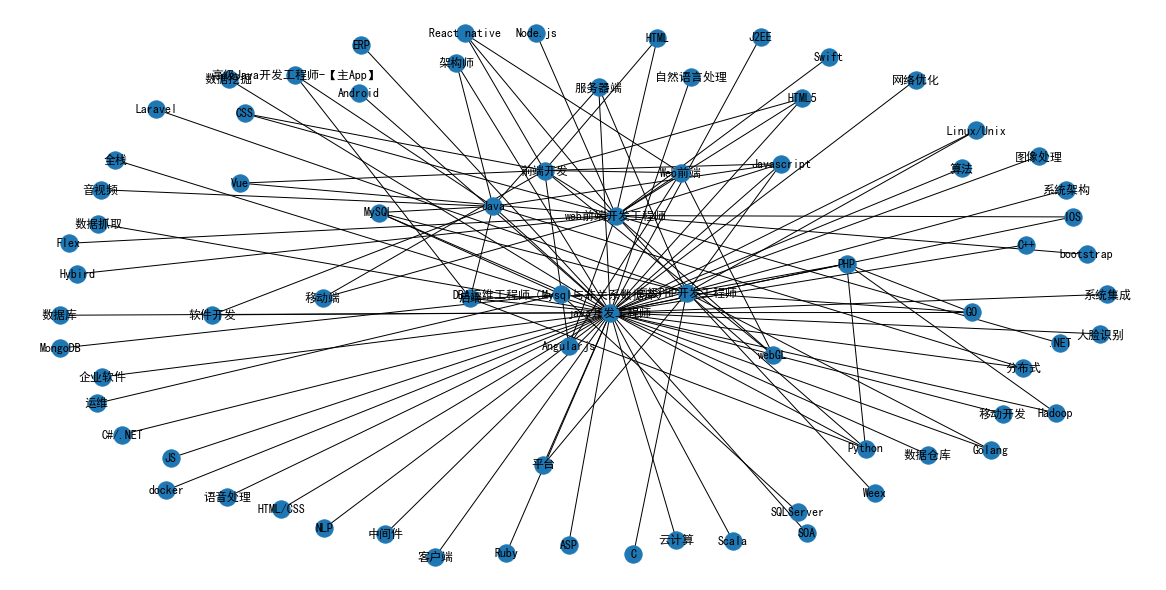

In [3]:
#step2:图可视化
position_name = data['positionName'].tolist()
skill_label = data['skillLables'].tolist()
#以职位名称为顶点，能力标签为边构建图
skill_position_graph = defaultdict(list)
for p,s in zip(position_name,skill_label):
    skill_position_graph[p] += eval(s) #字符串转化为列表
#print(skill_position_graph)
#print(len(skill_position_graph))
G = nx.Graph(skill_position_graph)
# 设置中文字体为黑体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 设置正常显示负号
plt.rcParams['axes.unicode_minus'] = False
# nx.spring_layout(graph)
# 随机取5个工作岗位
import random

sample_nodes = random.sample(position_name,k = 5)
# print(sample_nodes)
sample_nodes_connections  = sample_nodes
for p,skills in skill_position_graph.items():
    if p in sample_nodes:
        sample_nodes_connections += skills
# print(sample_nodes_connections)
#抽取原始G中的节点作为子图
sample_graph = G.subgraph(sample_nodes_connections)
plt.figure(figsize = (16,8))
pos = nx.spring_layout(sample_graph,k = 1)
nx.draw(sample_graph,pos,with_labels = True)
plt.show()

In [4]:
# 使用pagerank计算节点(技能)影响力
pr = nx.pagerank(G,alpha = 0.9)
ranked_position_ability = sorted([(name,value) for name,value in pr.items()],key = lambda x:x[1],reverse = True)
print(ranked_position_ability[:10]) #查看top10

[('后端', 0.026833573370768898), ('运维', 0.0191279829833669), ('Python', 0.01716937562136133), ('PHP', 0.015217301132452196), ('Java', 0.015099988114363864), ('UI', 0.013501957339680843), ('产品经理', 0.012867362096047103), ('测试', 0.012366790452249686), ('交互', 0.009849405953488204), ('MySQL', 0.00967223844507533)]


In [5]:
# 准备训练数据
# target:salary
X_data = data.drop(['salary'],axis = 1)
target = data['salary'].tolist()
#将特征转为文本
X_data['merged'] = X_data.apply(lambda x: ''.join(str(x)),axis = 1)
X_String = X_data['merged'].tolist()
print(len(X_String))

4511


In [6]:
import jieba
import re

def token(str):
    return re.findall('\w+',str) #匹配字母，数字，下划线

In [7]:
def get_one_row_job_string(x_string_row):
    #将特征合并为一行字符串
    job_string = ''
    for i,element in enumerate(x_string_row.split('\n')):
        if len(element.split()) == 2:
            _,value = element.split()
            if i == 0: #第0列为id,跳过
                continue
            else:
                job_string += value
    #print(job_string)
    return job_string    

In [8]:
#处理特征字符串
cutted_X = []
for i,row in enumerate(X_String):
    #print(row)
    job_string = get_one_row_job_string(row) #将特征合转为字符串
    #print(job_string)
    #print(type(job_string))
    cutted_X.append(' '.join(list(jieba.cut(' '.join(token(job_string)))))) #特征字符串分词处理
print(cutted_X[0])
print(len(cutted_X))        

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.325 seconds.
Prefix dict has been built successfully.


财务 产品 经理 海淀区 上 地 全职 物流 丨 运输   软件开发 500   2000 人 北京 福佑 多多 信息技术 有限公司 1   3 年 本科 福利待遇 好   创业 黑马   技术 氛围 好 https   www   lagou   com   jobs   7149613   html 岗位职责 1   负责 财务 相关 业务 解决方案 架构 并 主导 与 产品   技术 等 交付 团队 的 对接   能够 从 完整 的 财务   产品线
4511


In [19]:
# step3:提取文本特征tfidf
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cutted_X)
# print(X[0])
# target转化为数字：求每个target的平均值
print(target[:10])
target_numerical = [np.mean(list(map(float,re.findall('\d+',s)))) for s in target]
Y = target_numerical
print(Y[:10])
print(len(Y))

['10k-15k', '30k-50k', '40k-75k', '20k-40k', '20k-38k', '30k-50k', '40k-60k', '30k-50k', '40k-70k', '30k-50k']
[12.5, 40.0, 57.5, 30.0, 29.0, 40.0, 50.0, 40.0, 55.0, 40.0]
4511


In [37]:
# step4:使用KNN,SVM,LR模型进行训练
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
models = [KNeighborsRegressor(),SVR(),LinearRegression()]
for model in models:
    model.fit(X,Y)

In [42]:
# 预测函数
def predict_by_label(test_str,model):
    test_words = jieba.cut(test_str) #jieba分词
    test_vect = vectorizer.transform(test_words) #tfidf提取文本特征
    #print(test_vect)
    predict_value = model.predict(test_vect) #生成预测结果
    #print(predict_value)
    return predict_value[0]

In [43]:
# step5：基于指定能力关键词预测薪资
for model in models:    
    test = '测试 北京 专科 3年'
    print(test,'--',str(model)[:-2],':',predict_by_label(test,model))
    test = '测试 北京 专科 4年'
    print(test,'--',str(model)[:-2],':',predict_by_label(test,model))
    test = '算法 北京 本科 4年'
    print(test,'--',str(model)[:-2],':',predict_by_label(test,model))
    test = 'UI 北京 本科 4年'
    print(test,'--',str(model)[:-2],':',predict_by_label(test,model))
    test = '广州Java本科3年掌握大数据'
    print(test,'--',str(model)[:-2],':',predict_by_label(test,model))
    test = '沈阳Java硕士3年掌握大数据'
    print(test,'--',str(model)[:-2],':',predict_by_label(test,model))
    test = '沈阳Java本科3年掌握大数据'
    print(test,'--',str(model)[:-2],':',predict_by_label(test,model))
    test = '北京算法硕士3年掌握图像识别'
    print(test,'--',str(model)[:-2],':',predict_by_label(test,model))

测试 北京 专科 3年 -- KNeighborsRegressor : 15.1
测试 北京 专科 4年 -- KNeighborsRegressor : 15.1
算法 北京 本科 4年 -- KNeighborsRegressor : 25.5
UI 北京 本科 4年 -- KNeighborsRegressor : 17.0
广州Java本科3年掌握大数据 -- KNeighborsRegressor : 22.0
沈阳Java硕士3年掌握大数据 -- KNeighborsRegressor : 23.7
沈阳Java本科3年掌握大数据 -- KNeighborsRegressor : 23.7
北京算法硕士3年掌握图像识别 -- KNeighborsRegressor : 19.6
测试 北京 专科 3年 -- SVR : 14.093473983755642
测试 北京 专科 4年 -- SVR : 14.093473983755642
算法 北京 本科 4年 -- SVR : 21.167301075848883
UI 北京 本科 4年 -- SVR : 17.795295109969743
广州Java本科3年掌握大数据 -- SVR : 20.896012053048537
沈阳Java硕士3年掌握大数据 -- SVR : 20.7875612998051
沈阳Java本科3年掌握大数据 -- SVR : 20.7875612998051
北京算法硕士3年掌握图像识别 -- SVR : 23.17021574956597
测试 北京 专科 3年 -- LinearRegression : 13.391350824462044
测试 北京 专科 4年 -- LinearRegression : 13.391350824462044
算法 北京 本科 4年 -- LinearRegression : 22.390293478535998
UI 北京 本科 4年 -- LinearRegression : 15.23547220645831
广州Java本科3年掌握大数据 -- LinearRegression : 25.8606420976985
沈阳Java硕士3年掌握大数据 -- LinearRegression : 22.028598534269